In [6]:
import os
import sys

import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots

In [4]:
# import sys
# !{sys.executable} -m pip install cmasher

import cmasher as cmr

In [4]:
def print_spec_urls(tgid_list,max_num=10):
    for ti in tgid_list[:max_num]:
        print("https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid%d"%ti )
    

    

## NNMF analysis code!

In [14]:
# to read the data, one can do

save_path = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/desi_y1_dwarf_nnmf_result.h5"
with h5py.File(save_path, "r") as f:
    tgids = f["TARGETID"][:]
    zreds = f["Z"][:]
    wave_rest = f["WAVE_REST"][:]
    flux_scale = f["FLUX_NORM"][:]
    flux_ivar_scale = f["FLUX_IVAR_NORM"][:] 
    scales = f["NORM_FACTOR"][:] 
    nnmf_coeffs = f["NNMF_COEFFS"][:]
    nnmf_rnorm = f["NNMF_RNORM"][:]    
    is_valid = f["IS_VALIDATION"][:] 



In [15]:
_,unique_nnmf_inds = np.unique(tgids, return_index=True)

In [16]:
tgids_unique = tgids[unique_nnmf_inds ]

print(len(tgids_unique))

244279


In [29]:
data_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v3.fits")
data_cat = data_cat[ data_cat["LOGM_SAGA"] < 9 ]

In [18]:
tgids_cat_unique, tgid_cat_unique_inds = np.unique(data_cat["TARGETID"].data, return_index=True)


In [19]:
len(tgids_cat_unique)

244312

In [22]:
## find the inds from tgids_cat_unique that appear in tgids_unique
isin_mask = np.isin(tgids_cat_unique, tgids_unique)

In [10]:
## given these target ids, can I get the various parameters like SAMPLE, AND VARIOUS FLUX LINES??
line_names = ["OII_3726", "OII_3729", "HGAMMA", "OIII_4363", "HBETA", "OIII_4959", "OIII_5007", "NII_6548", "HALPHA", "NII_6584", "SII_6716", "SII_6731"]

flux_and_ivar_keys = []
for name in line_names:
    flux_and_ivar_keys.append(f"{name}_FLUX")
    flux_and_ivar_keys.append(f"{name}_FLUX_IVAR")

# If you want to print the final list:
print(flux_and_ivar_keys)

columns_needed = ["TARGETID","HALPHA_EW", "HALPHA_EW_IVAR"] + flux_and_ivar_keys




['OII_3726_FLUX', 'OII_3726_FLUX_IVAR', 'OII_3729_FLUX', 'OII_3729_FLUX_IVAR', 'HGAMMA_FLUX', 'HGAMMA_FLUX_IVAR', 'OIII_4363_FLUX', 'OIII_4363_FLUX_IVAR', 'HBETA_FLUX', 'HBETA_FLUX_IVAR', 'OIII_4959_FLUX', 'OIII_4959_FLUX_IVAR', 'OIII_5007_FLUX', 'OIII_5007_FLUX_IVAR', 'NII_6548_FLUX', 'NII_6548_FLUX_IVAR', 'HALPHA_FLUX', 'HALPHA_FLUX_IVAR', 'NII_6584_FLUX', 'NII_6584_FLUX_IVAR', 'SII_6716_FLUX', 'SII_6716_FLUX_IVAR', 'SII_6731_FLUX', 'SII_6731_FLUX_IVAR']


In [12]:
from desi_lowz_funcs import get_tgids_fastspec

fastspec_table = get_tgids_fastspec(tgids, columns_needed)


In [30]:
fastspec_table_ordered = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/desi_y1_dwarf_fastspec_cols.fits")

In [34]:
## we need to first boil down to the unique values and then to the sorting values1
fspec_tgids = fastspec_table[0]["TARGETID"]
_,unique_inds_fspec = np.unique(fspec_tgids,return_index=True)
sort_inds_fspec = np.argsort(fspec_tgids[unique_inds_fspec])


In [38]:
fspec_tgids[unique_inds_fspec][sort_inds_fspec] - tgids_unique
##looks like the targetid are matching!!

array([0, 0, 0, ..., 0, 0, 0])

In [93]:
## load the nnmf templates !
nnmf_temps = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/nnmf_templates/templates_dwarfs.npy")
print(nnmf_temps.shape)

(3980, 10)


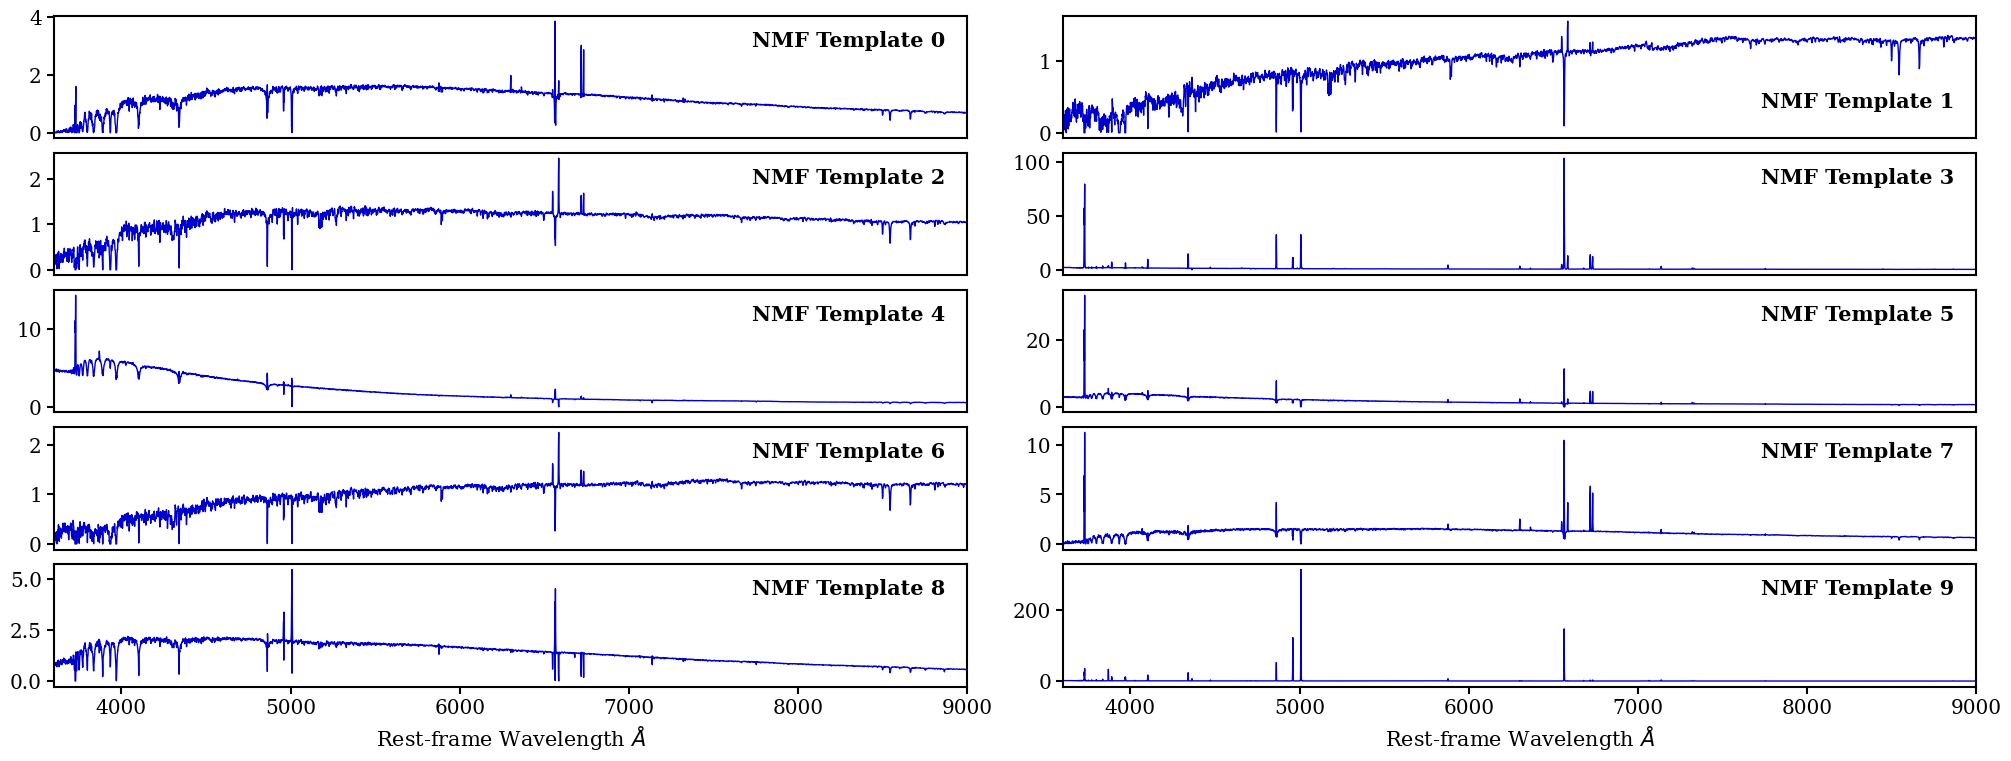

In [47]:
fig, ax = plt.subplots(5, 2, figsize=(20, 7.5), layout="constrained")

for i in range(10):
    row, col = divmod(i, 2)
    ax[row, col].plot(wave_rest, nnmf_temps[:, i], color="mediumblue", lw=1)
    ax[row, col].set_xlim([3600, 9000])

    yloc = 0.3 if i == 1 else 0.8

    ax[row, col].text(0.87, yloc, f"NMF Template {i}", ha='center', va='center', fontsize=15,
                      transform=ax[row, col].transAxes, weight="bold")

    if row != 4:
        ax[row, col].set_xticks([])
    else:
        ax[row, col].set_xlabel(r"Rest-frame Wavelength $\AA$", fontsize=15)

plt.savefig("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/plots/nnmf_templates.pdf", bbox_inches="tight")
plt.show()


In [105]:
# from brokenaxes import brokenaxes

In [106]:
from spectra_encoder import get_nnmf_fit

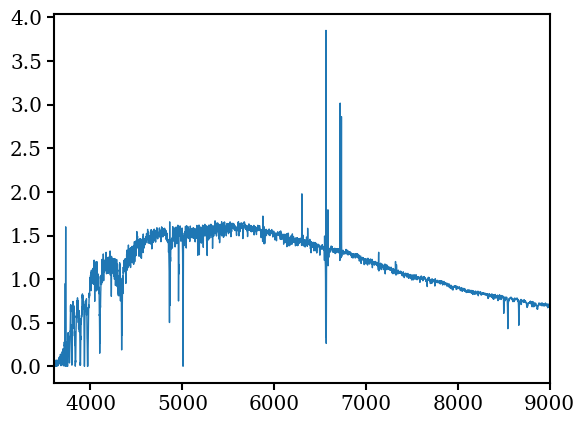

In [107]:
plt.plot(wave_rest, nnmf_temps[:,0],lw=1)
plt.xlim([3600,9000])
plt.show()

39628420161735550


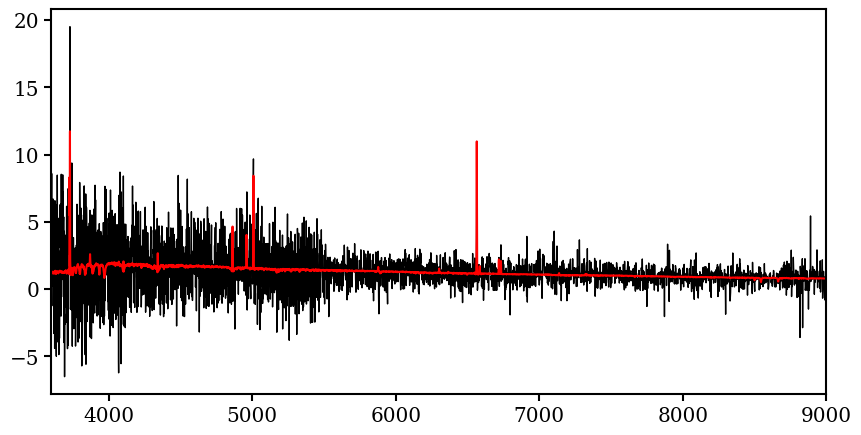

In [66]:
obji = 5

print(tgids[1000])


fit_i = get_nnmf_fit(nnmf_coeffs[obji], nnmf_temps)

plt.figure(figsize = (10,5))
plt.plot(wave_rest, flux_scale[:,obji],lw=1,color = "k")

plt.plot(wave_rest, fit_i, color = "r")

plt.xlim([3600,9000])
plt.show()

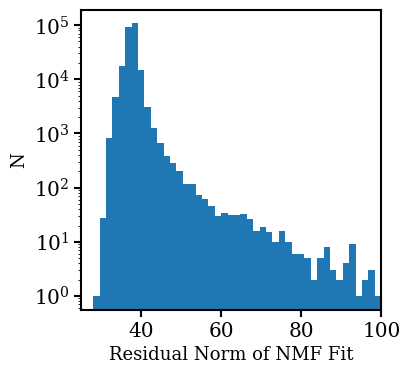

In [60]:
ax = make_subplots(ncol = 1, nrow=1)

ax[0].hist(nnmf_rnorm,bins = 50,range = (20,100))
ax[0].set_xlim([25,100])
ax[0].set_yscale("log")
ax[0].set_xlabel(r"Residual Norm of NMF Fit",fontsize = 13)
ax[0].set_ylabel(r"N",fontsize = 13)
plt.savefig("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/plots/nmf_fit_rnorm.pdf",bbox_inches="tight")
plt.show()

In [92]:
np.where(nnmf_rnorm > 70)[0]

array([    83,    782,   1714,   2004,   2327,   2368,   4634,   5786,
         6276,   6368,   8142,   8504,   8519,   8787,   9214,  10852,
        12072,  14153,  14180,  14425,  14700,  15276,  15376,  15931,
        17273,  18989,  19352,  19489,  19966,  20346,  20983,  23594,
        26032,  26187,  27457,  29497,  30526,  30959,  31426,  31683,
        33598,  33674,  33826,  34383,  35736,  35738,  35920,  36887,
        37892,  37979,  38581,  38642,  40104,  40653,  40662,  41204,
        41536,  42484,  43152,  47573,  47581,  48339,  48357,  50590,
        50618,  50900,  51278,  51374,  51382,  51459,  52206,  52688,
        53438,  53631,  53925,  55031,  55498,  55922,  57224,  57716,
        58369,  59002,  63502,  63620,  65230,  66344,  67108,  67474,
        71000,  72365,  73171,  73647,  74868,  77424,  77976,  78832,
        79061,  83548,  84358,  84751,  85374,  85628,  85711,  85852,
        86197,  86554,  87421,  87860,  88023,  88468,  88769,  88925,
      

In [93]:
# 39627921169584741, 39627630869219269


np.where(tgids == 39627921169584741)

(array([16585]),)

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627845927964294


/tmp/ipykernel_2202786/4243869785.py:26: RuntimeWarning: divide by zero encountered in true_divide
  noise_i = np.sqrt(1/flux_ivar_scale[:, obji])  # Extract noise for this object


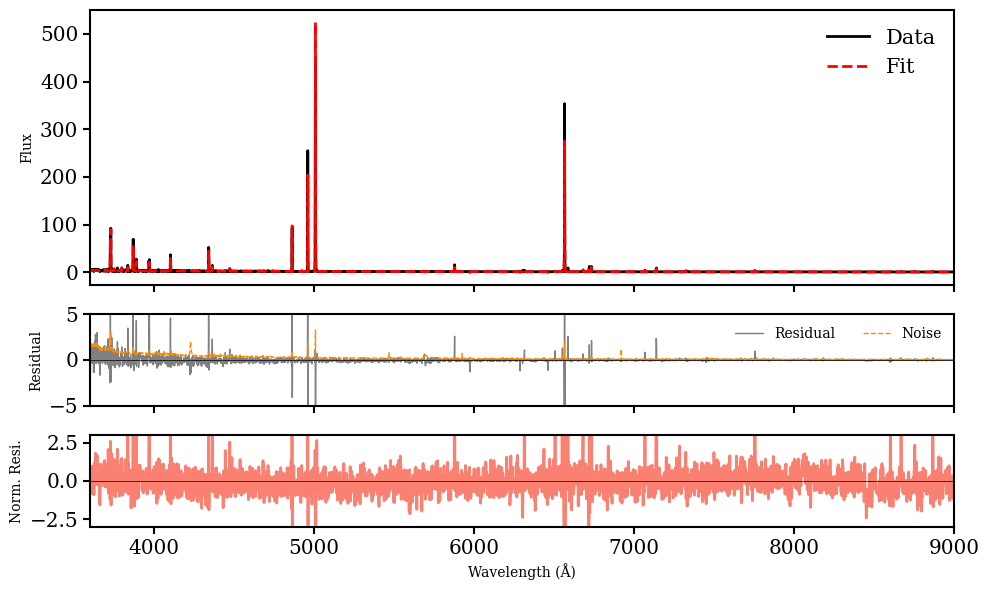

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627851888072856


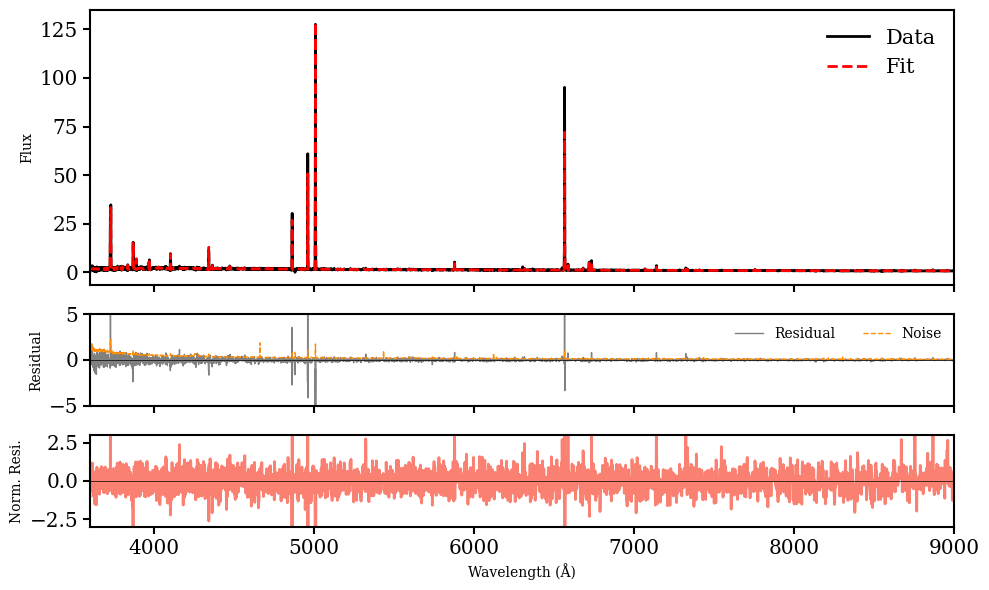

In [26]:
import matplotlib.pyplot as plt

# Assume you already have:
# wave_rest: 1D array of wavelengths
# flux_scale[:, obji]: observed flux
# fit_i: model fit (same shape as flux)
# noise[:, obji]: noise values (same shape)

# inds = np.where(zreds < 0.005)[0][:30]
inds = np.where(nnmf_rnorm > 50)[0]

##these high reconstruction error galaxies are very interesting!!!

for obji in inds[:2]:
# for obji in range(1):

    # obji = 13


    print("https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid%d"%tgids[obji] )
    
    # Compute residual
    fit_i = get_nnmf_fit(nnmf_coeffs[obji], nnmf_temps)
    
    residual = flux_scale[:, obji] - fit_i
    noise_i = np.sqrt(1/flux_ivar_scale[:, obji])  # Extract noise for this object
    
    # Create a 2-panel figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True, 
                                   gridspec_kw={'height_ratios': [3,1,1]})
    
    # Top panel: Data and fit
    ax1.plot(wave_rest, flux_scale[:, obji], lw=2, color="k", label="Data")
    ax1.plot(wave_rest, fit_i, color="r", label="Fit",ls = "--",lw = 2)
    ax1.set_ylabel("Flux")
    ax1.legend(fontsize = 15)
    ax1.set_xlim([3600, 9000])
    
    # Bottom panel: Residuals and noise
    ax2.plot(wave_rest, residual, color="gray", lw=1, label="Residual")
    ax2.plot(wave_rest, noise_i, color="darkorange", lw=1, linestyle="--", label="Noise")
    # ax2.set_xlabel("Wavelength (Å)")
    ax2.set_ylabel("Residual")
    ax2.set_ylim([-5,5])
    ax2.axhline(0, color="k", lw=0.5)
    ax2.legend(ncol = 2)
    
    # Bottom panel: Residuals and noise
    ax3.plot(wave_rest, residual / noise_i, color="salmon", lw=2, label="Residual / Noise")
    # ax3.plot(wave_rest, noise_i, color="darkorange", lw=0.8, linestyle="--", label="Noise")
    ax3.set_xlabel("Wavelength (Å)")
    ax3.set_ylabel("Norm. Resi.")
    ax3.set_ylim([-3,3])
    ax3.axhline(0, color="k", lw=0.5)
    # ax3.legend()
    
    plt.tight_layout()
    plt.savefig("../../plots/nnmf_fit_eg_ano.png",dpi=300,bbox_inches="tight")
    plt.show()


In [ ]:
all_inputs = []

for i in trange(flux_scale.shape[1]):
    all_inputs.append(  (flux_scale[:,i], flux_ivar_scale[:,i], nnmf_coeffs[i] )   )
    

In [ ]:
all_inputs[0][0].shape, all_inputs[0][1].shape, all_inputs[0][2].shape

In [ ]:
## construct the residuals now 

from spectra_encoder import parallel_residual
all_norm_resis = parallel_residual(all_inputs,  n_processes=64)


In [ ]:
all_norm_resis.shape


In [ ]:
# np.save( "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/norm_residuals_dwarfs.npy", all_norm_resis )
all_norm_resis = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/norm_residuals_dwarfs.npy"  )



In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    @staticmethod
    def _svd_flip(u, v, u_based_decision=True):
        """
        Adjusts the signs of the singular vectors from the SVD decomposition for
        deterministic output.

        This method ensures that the output remains consistent across different
        runs.

        Args:
            u (torch.Tensor): Left singular vectors tensor.
            v (torch.Tensor): Right singular vectors tensor.
            u_based_decision (bool, optional): If True, uses the left singular
              vectors to determine the sign flipping. Defaults to True.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Adjusted left and right singular
              vectors tensors.
        """
        if u_based_decision:
            max_abs_cols = torch.argmax(torch.abs(u), dim=0)
            signs = torch.sign(u[max_abs_cols, range(u.shape[1])])
        else:
            max_abs_rows = torch.argmax(torch.abs(v), dim=1)
            signs = torch.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, None]
        return u, v

    @torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = self._svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

# if __name__ == "__main__":
#     import numpy as np
#     from sklearn.decomposition import PCA as sklearn_PCA
#     from sklearn import datasets
#     iris = torch.tensor(datasets.load_iris().data)
#     _iris = iris.numpy()
#     devices = ['cpu']
#     if torch.cuda.is_available():
#         devices.append('cuda')
#     for device in devices:
#         iris = iris.to(device)
#         for n_components in (2, 4, None):
#             _pca = sklearn_PCA(n_components=n_components).fit(_iris)
#             _components = torch.tensor(_pca.components_)
#             pca = PCA(n_components=n_components).to(device).fit(iris)
#             components = pca.components_
#             assert torch.allclose(components, _components.to(device))
#             _t = torch.tensor(_pca.transform(_iris))
#             t = pca.transform(iris)
#             assert torch.allclose(t, _t.to(device))
#         __iris = pca.inverse_transform(t)
#         assert torch.allclose(__iris, iris)
#     print("passed!")

### Put a PCA on the residuals!!

In [110]:
# from sklearn.decomposition import PCA
# import umap
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [116]:

X = torch.tensor(all_norm_resis, dtype=torch.float32)

# pca = PCA(n_components=20).to(device).fit(X)


In [111]:
## how to save this pca object?

# torch.save(pca, "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/desi_dwarfs_pca.pt")

torch.serialization.add_safe_globals({'PCA': PCA})
pca = torch.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/desi_dwarfs_pca.pt", weights_only=False)


In [112]:
# To inspect the PCA templates:
templates = pca.components_  

In [113]:
templates_arr = templates.cpu().numpy()

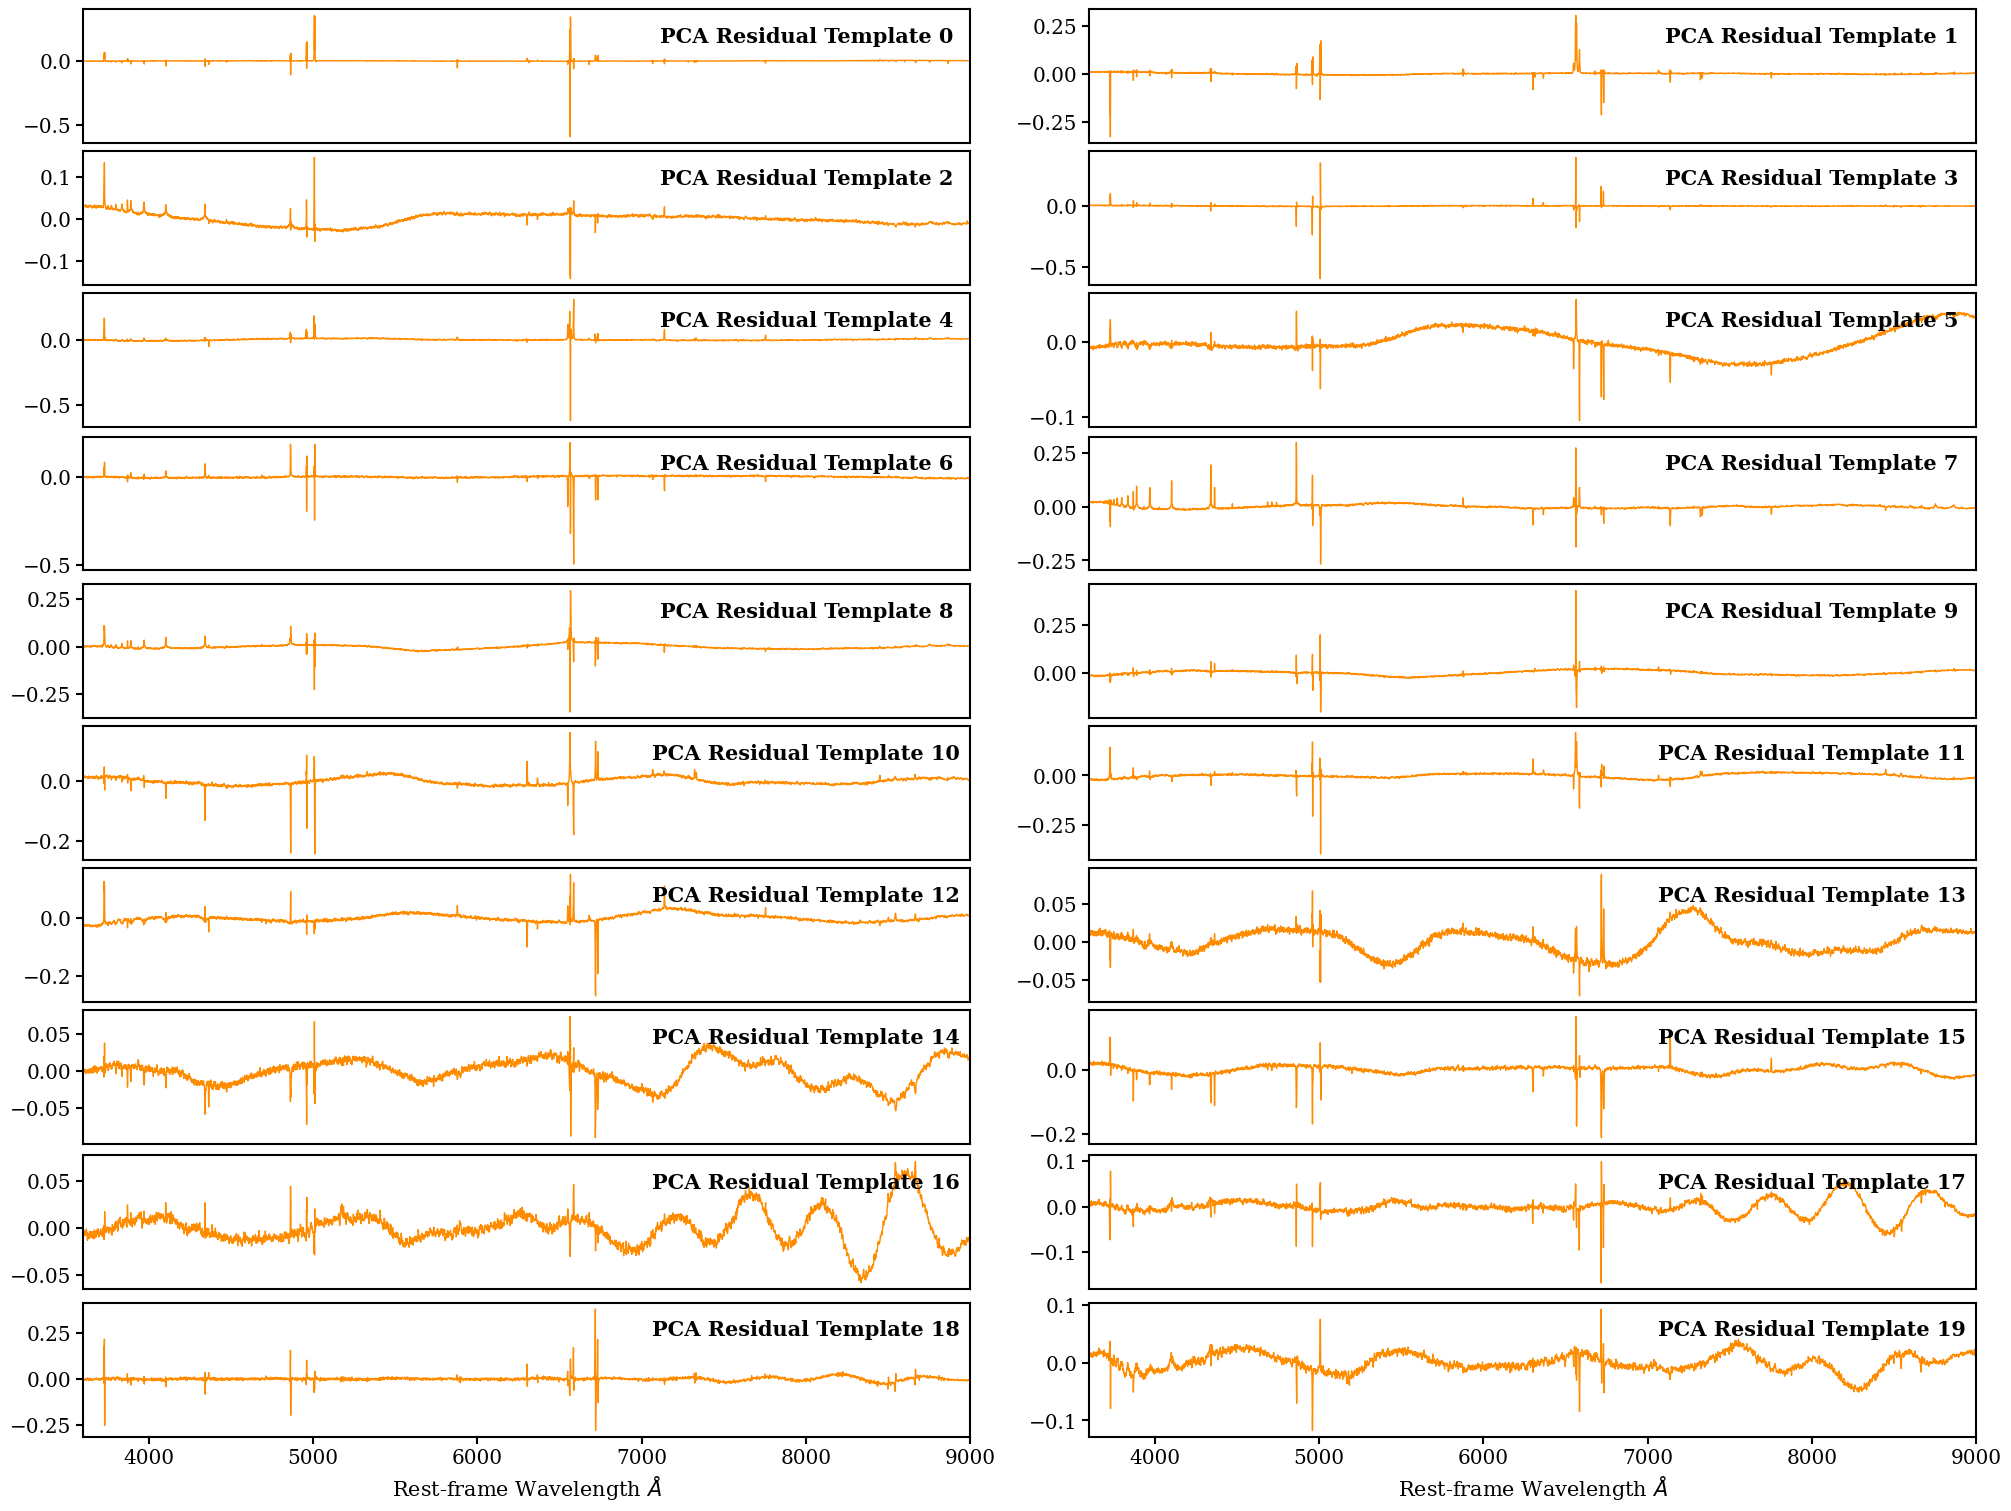

In [114]:

fig, ax = plt.subplots(10, 2, figsize=(20, 15), layout="constrained")

for i in range(20):
    # For a 10x2 grid, we need to calculate the position of each plot
    row, col = divmod(i, 2)
    
    ax[row, col].plot(wave_rest, templates_arr[i], color="darkorange", lw=1)
    ax[row, col].set_xlim([3600, 9000])

    # if i == 1:
    #     yloc = 0.3
    # else:
    yloc = 0.8

    ax[row, col].text(0.815, yloc, f"PCA Residual Template {i}", ha='center', va='center', fontsize=15,
                      transform=ax[row, col].transAxes, weight="bold")
    
    if row != 9:
        ax[row, col].set_xticks([])
    else:
        ax[row, col].set_xlabel(r"Rest-frame Wavelength $\AA$", fontsize=15)

# Save or display the plot
# plt.savefig("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/plots/pca_templates.pdf", bbox_inches="tight")
plt.show()


In [117]:
t = pca.transform(X)

In [118]:
t.shape

torch.Size([245838, 20])

In [119]:
## now let us visualize this pca space!!!

t_arr = t.cpu().numpy()


In [ ]:
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

reducer = umap.UMAP()
scaled_t_arr = StandardScaler().fit_transform(t_arr)

print(scaled_t_arr[0])

embedding = reducer.fit_transform(scaled_t_arr)
embedding.shape


In [ ]:
# Visualize the result
# Randomly choose indices
rndp = np.random.choice(len(tgids), 50000, replace=False)

x_emb = embedding[:, 0][rndp]
y_emb = embedding[:, 1][rndp]
plt.scatter(x_emb, y_emb,s=1, c = nnmf_rnorm[rndp],vmin=30,vmax=50,cmap = "Reds")
plt.title('2D UMAP Projection of Residuals')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.xlim([x_emb.min(), x_emb.max()])
plt.ylim([y_emb.min(), y_emb.max()])
plt.show()

In [ ]:
mask = (x_emb > 8) & (x_emb < 9) & (y_emb < -2)
tgids_interest = tgids[rndp][mask]
print_spec_urls(tgids_interest)


In [74]:
# # # # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install brokenaxes

# !{sys.executable} -m pip uninstall -y \
#     "cudf-cu12==25.4.*" "dask-cudf-cu12==25.4.*" "cuml-cu12==25.4.*" \
#     "cugraph-cu12==25.4.*" "nx-cugraph-cu12==25.4.*" "cuspatial-cu12==25.4.*" \
#     "cuproj-cu12==25.4.*" "cuxfilter-cu12==25.4.*" "cucim-cu12==25.4.*" \
#     "pylibraft-cu12==25.4.*" "raft-dask-cu12==25.4.*" "cuvs-cu12==25.4.*" \
#     "nx-cugraph-cu12==25.4.*"





In [ ]:
# now let us combine the 20 PCA residual dimension and 10 NNMF coefficient dimensions!!

In [ ]:
t_arr.shape

In [ ]:
nnmf_coeffs.shape

In [ ]:
## let us now vstack theses

In [120]:
all_spec_feats = np.concatenate( [nnmf_coeffs, t_arr], axis = 1 )

print(all_spec_feats.shape)

(245838, 30)


In [ ]:
reducer = umap.UMAP()
scaled_t_arr = StandardScaler().fit_transform(all_spec_feats)

print(scaled_t_arr[0])

embedding = reducer.fit_transform(scaled_t_arr)
embedding.shape

In [96]:
print(np.percentile(nnmf_rnorm, 99.79))
print(np.percentile(nnmf_rnorm, 100-99.79))



54.104661734390525
32.43049462165831


/tmp/ipykernel_773139/3063015700.py:14: RuntimeWarning: invalid value encountered in true_divide
  averaged_hist = hist/counts


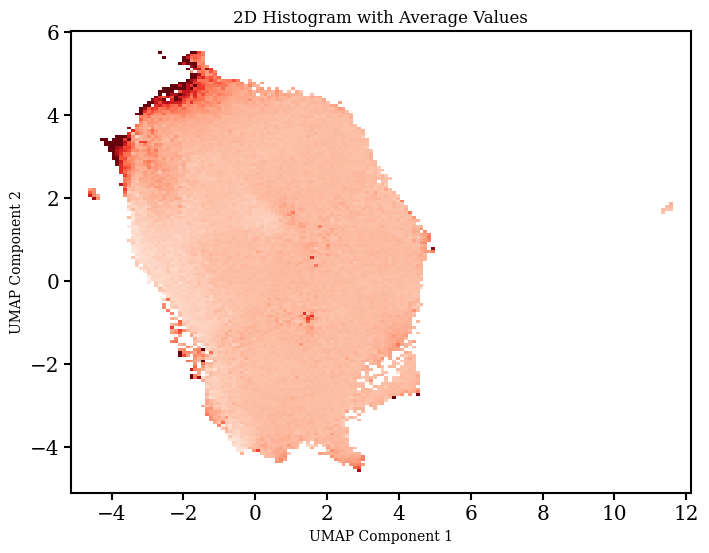

In [112]:
# Step 2: Create a 2D histogram
# Define the number of bins you want for the histogram
n_bins = 150

# Calculate the 2D histogram, where 'umap_embedding[:, 0]' is x-axis and 'umap_embedding[:, 1]' is y-axis
# 'Y' is the second parameter for averaging
hist, xedges, yedges = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=n_bins, weights=nnmf_rnorm)

# Step 3: Calculate the number of points in each bin
counts, _, _ = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=n_bins)

# Step 4: Compute the average for each bin
# Avoid division by zero by adding a small value to the counts
averaged_hist = hist/counts
# averaged_hist = np.divide(hist, counts, where=(counts != 0))


# Step 5: Plot the results
# Use pcolormesh to plot the average values of the second parameter in each bin
plt.figure(figsize=(8, 6))
plt.pcolormesh(xedges, yedges, averaged_hist.T, shading='auto', cmap='Reds',vmin=32.5,vmax=54) #,norm=LogNorm(vmin=20,vmax = 150))
# plt.colorbar(label='Average of second parameter (Y)')
plt.title('2D Histogram with Average Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.xlim([x_emb2.min()-0.5, x_emb2.max()+0.5])
plt.ylim([y_emb2.min()-0.5, y_emb2.max()+0.5])
plt.savefig("../../plots/umap_spectra_rnorm.pdf",bbox_inches="tight",dpi=150)
plt.show()


/tmp/ipykernel_813597/1955374711.py:19: RuntimeWarning: invalid value encountered in true_divide
  averaged_hist = hist/counts


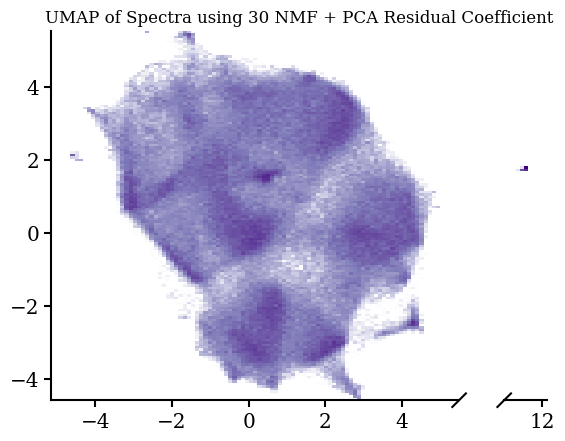

In [86]:
from brokenaxes import brokenaxes
import matplotlib.pyplot as plt

# Adjust as needed: [start, break_point], [cluster_start, cluster_end]
bax = brokenaxes(xlims=((embedding[:,0].min() - 0.5, 5.5), (11, embedding[:,0].max() + 0.5)), hspace=.05)


n_bins = 150

# Calculate the 2D histogram, where 'umap_embedding[:, 0]' is x-axis and 'umap_embedding[:, 1]' is y-axis
# 'Y' is the second parameter for averaging
hist, xedges, yedges = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=n_bins, weights=nnmf_rnorm)

# Step 3: Calculate the number of points in each bin
counts, _, _ = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=n_bins)

# Step 4: Compute the average for each bin
# Avoid division by zero by adding a small value to the counts
averaged_hist = hist/counts
# averaged_his

# Step 5: Plot the results
# Use pcolormesh to plot the average values of the second parameter in each bin
# plt.figure(figsize=(8, 6))
bax.set_title("UMAP of Spectra using 30 NMF + PCA Residual Coefficient")
bax.pcolormesh(xedges, yedges, counts.T, shading='auto', cmap='Purples',norm=LogNorm()) #,norm=LogNorm(vmin=20,vmax = 150))
# bax.set_xlabel('UMAP Component 1')
# bax.set_ylabel('UMAP Component 2')
plt.savefig("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/plots/umap_spectra_count.pdf",bbox_inches="tight",dpi=150)
plt.show()




In [114]:
embedding[:,0][nnmf_rnorm > 100]

array([-4.1903   , -2.5963604, -4.1597004, -4.192416 , -4.1946993,
       -4.186842 , -4.2061486,  4.5320773, -4.191865 , -4.2173667,
       -4.1813416, -4.2228103, -1.7414428, -2.654666 , -4.11064  ,
       -4.2176404, -4.197551 , -2.573751 , -4.227402 , -4.2125473,
       -4.1373916, -2.5233567, -4.1720057, -4.2225385, -3.1581848,
        1.7660758, -1.4727464, -2.6377456, -0.8253673, -4.216353 ],
      dtype=float32)

In [103]:
mask = (y_emb2 < -2.5) & (x_emb2 > 4)
tgids_interest = tgids[rndp2][mask]
print_spec_urls(tgids_interest)

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627630705642145
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633349760779223
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627613395749551
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628352339837679
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633296329540741
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627648753734714
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627721814316097
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39632971799462201
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627885018875313
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627629027924100


In [ ]:
mask = (x_emb2 > 10)
tgids_interest = tgids[rndp2][mask]
print_spec_urls(tgids_interest)

## the very anomalous point is the high redshift ELG points

In [99]:
np.save("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/desi_dwarfs_umap_nnmf_and_pca.npy", embedding)

In [94]:
embedding = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/desi_dwarfs_umap_nnmf_and_pca.npy")

In [69]:
len(nnmf_rnorm[nnmf_rnorm > 60])

327

In [154]:
interesting_mask = (nnmf_rnorm > 50)

In [132]:
# tgids_interest = tgids[mask]
# print_spec_urls(tgids_interest)

/tmp/ipykernel_773139/2101607397.py:14: RuntimeWarning: invalid value encountered in true_divide
  averaged_hist = hist/counts


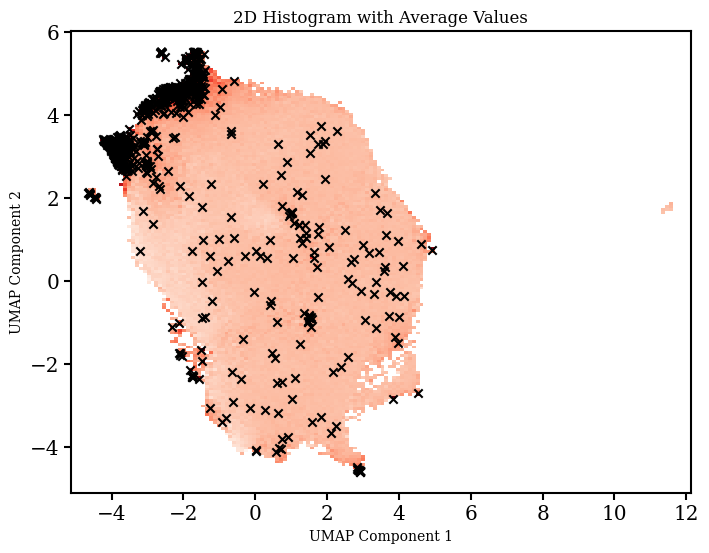

In [133]:
# Step 2: Create a 2D histogram
# Define the number of bins you want for the histogram
n_bins = 150

# Calculate the 2D histogram, where 'umap_embedding[:, 0]' is x-axis and 'umap_embedding[:, 1]' is y-axis
# 'Y' is the second parameter for averaging
hist, xedges, yedges = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=n_bins, weights=nnmf_rnorm)

# Step 3: Calculate the number of points in each bin
counts, _, _ = np.histogram2d(embedding[:, 0], embedding[:, 1], bins=n_bins)

# Step 4: Compute the average for each bin
# Avoid division by zero by adding a small value to the counts
averaged_hist = hist/counts
# averaged_hist = np.divide(hist, counts, where=(counts != 0))


# Step 5: Plot the results
# Use pcolormesh to plot the average values of the second parameter in each bin
plt.figure(figsize=(8, 6))
plt.pcolormesh(xedges, yedges, averaged_hist.T, shading='auto', cmap='Reds',vmin=32.5,vmax=54) #,norm=LogNorm(vmin=20,vmax = 150))

plt.scatter( embedding[:,0][interesting_mask], embedding[:,1][interesting_mask],color = "k", marker ="x")


# plt.colorbar(label='Average of second parameter (Y)')
plt.title('2D Histogram with Average Values')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.xlim([x_emb2.min()-0.5, x_emb2.max()+0.5])
plt.ylim([y_emb2.min()-0.5, y_emb2.max()+0.5])
# plt.savefig("../../plots/umap_spectra_rnorm.pdf",bbox_inches="tight",dpi=150)
plt.show()


In [88]:
## now given the regions of interest, find the black crosses that intersect there!!

def get_tgids_weird(cen_x, cen_y, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) ):
    x_f, y_f = embedding[:,0][interesting_mask], embedding[:,1][interesting_mask]

    dists = np.sqrt( (x_f - cen_x)**2 + (y_f - cen_y)**2 )
    
    region_mask = (dists < radius)

    #get the targetids of objects that one wants to inspect, 
    tgids_mask = tgids[interesting_mask][region_mask]

    #then we print all these targetids!
    print_spec_urls(tgids_mask)
    return 
    
    
    

In [137]:
get_tgids_weird(-2.0391770358506847, -1.8194660663553126, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) )
##these are ones that have a normalization offset!!

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627480146909653
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633452651251163
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627893935970905


In [143]:
get_tgids_weird(1.7291655000167987, 0.3952647081882015, radius = 0.2, interesting_mask = (nnmf_rnorm > 50) )
#

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633448956071003
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628188388693712


In [144]:
get_tgids_weird(-2.5698253945143192, 5.458846192614825, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) )
## these are weird objects, they all have a redshift of z~0.03 and have a big unphysical dip near the redshift OIII line. The redshift also is wrong !

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628089902241934
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627838411773877
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628296840809365
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628518111318795
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633011137842888
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633039990459396
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633100581375672
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633049293426694
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628166188240223
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628348267169678


In [145]:
get_tgids_weird(-4.469945232788648, 2.078376471378811, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) )
##this seems like some flux normalization issue where the blue part is weirdly sloped

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627998281862262
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627380314083367
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633424423584658


In [146]:
get_tgids_weird(-1.7158152922597925, 5.369486412728989, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) )
##these look like AGN galaxies with blue slopes and do not look like dwarf galaxies

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628356001467740
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633529201493350
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628013624626059


In [148]:
get_tgids_weird(-2.3077491684119744, 4.542161792870182, radius = 0.05, interesting_mask = (nnmf_rnorm > 50) )
##these are very blue, high emission line star-forming regions in dwarfs!!

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633462935684765
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628498989483423
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39637143286450337


In [152]:
get_tgids_weird(-3.0002575962906137, 4.155513493939019, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) )
##these are also very blue star forming regions in galaxies!! some He II emission is also seen!

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633034554639391
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627994867699225
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628309243366322
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633059447838286
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627711647320318
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627593040790155
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628064035966534
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39632952031710982
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627844418013010
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627891423579679


In [153]:
get_tgids_weird(0.9591989875345783, 1.5417697985149, radius = 0.1, interesting_mask = (nnmf_rnorm > 50) )
##the first one is a star-galaxy blend and the other one seems to have weird normalization issues,

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627666323671508
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627659088496302


In [156]:
get_tgids_weird(2.8962334942376815, -4.557990898264398, radius = 0.1, interesting_mask = (nnmf_rnorm > 60) )
## is a blue arm flux calibration issue it seems!

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628392349308664
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627759722431975
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627380314080359
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627415139385461


In [157]:
get_tgids_weird(-1.6744206883420887, -2.3486360463076004, radius = 0.1, interesting_mask = (nnmf_rnorm > 60) )
##is another flux calibration issue!

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633355016242699
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628472498258195


In [160]:
get_tgids_weird(-3.8772497676033466, 3.2052594442640014, radius = 0.1, interesting_mask = (nnmf_rnorm > 60) )
##the slopes are very blue, very young stellar populations

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627890781850778
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627907856863316
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627794660985791
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39632931773219562


In [127]:

##this is the latent space for a SNe
## let us compute the similarity scores!

(30,)

In [160]:
# import torch
# import torch.nn.functional as F

# your reference vector (shape: (50,))
ref_vector = torch.tensor(all_spec_feats[tgids == 39628158944675316].squeeze(0), dtype=torch.float32)

# matrix of other vectors (shape: (N, 50))
other_vectors = torch.tensor(all_spec_feats, dtype=torch.float32)

# normalize both
ref_norm = F.normalize(ref_vector, dim=0)  # shape: (50,)
others_norm = F.normalize(other_vectors, dim=1)  # shape: (N, 50)

# cosine similarity = dot product after normalization
cos_similarities = torch.matmul(others_norm, ref_norm)  # shape: (N,)

# get top-k most similar
top_k = 40
top_similarities, top_indices = torch.topk(cos_similarities, k=top_k)

In [161]:
print_spec_urls(tgids[top_indices[10:20]],max_num=30)

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633260732483041
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39632955370375225
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627902718838268
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628135972472175
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627953855794510
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39633283117482310
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628182478918726
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627729619910948
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627678533290592
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628042418523519


In [156]:
np.save("/pscratch/sd/v/virajvm/weird_tgids.npy", tgids[interesting_mask])

In [157]:
print_spec_urls( tgids[interesting_mask] )

https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627845927964294
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627851888072856
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627900168701450
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39627906200112534
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628179014422328
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628219317486724
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628298862462912
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628338104369928
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628446929785286
https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid39628468102627592


In [135]:
# get_tgids_weird(1.4411952467884461, -0.8730348949641797, radius = 0.2, interesting_mask = (nnmf_rnorm > 50) )
### very weird broad emission line AGN like object